In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
def get_origin_mgrid(sidelen1,sidelen2, dim=2):
    if sidelen1 >=sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen1)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    
      minor=int((sidelen1-sidelen2)/2)
      mgrid=mgrid[:,minor:sidelen2+minor]
    if sidelen1 <sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen2)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
      
      minor=int((sidelen2-sidelen1)/2)
      mgrid=mgrid[minor:sidelen1+minor,:]
    mgrid = mgrid.reshape(-1, dim)
   
    return mgrid

In [3]:
#SIREN model  https://github.com/vsitzmann/siren
class SineLayer(nn.Module):
 
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output  

In [4]:
from scipy.io import loadmat
data=loadmat("data.mat")
d_nmo=data['d_nmo']
noisy_tensor = torch.from_numpy(np.expand_dims(d_nmo,axis=0)).float()

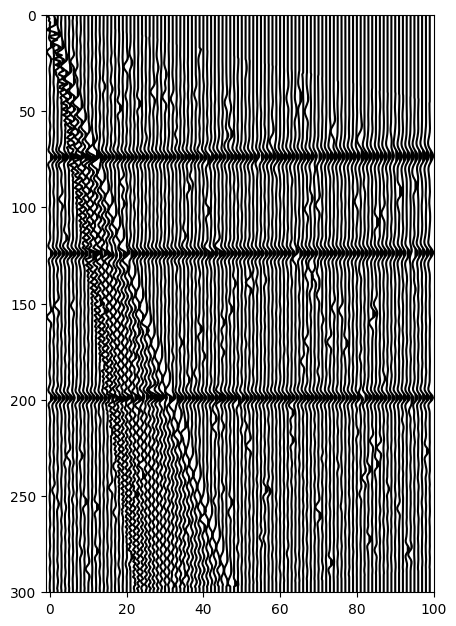

In [5]:
from wiggle import wiggle
plt.figure(figsize=(5,7.5))
wiggle(d_nmo,color='k', sf=0.3)

In [ ]:
coords = get_origin_mgrid(noisy_tensor.shape[1],noisy_tensor.shape[2],dim=2)
desired_shape = (d_nmo.shape[0]*d_nmo.shape[1],1)
pixels= noisy_tensor.reshape(desired_shape)
model_input = coords.unsqueeze(0)
ground_truth=pixels.unsqueeze(0)

c:\Users\ilove\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
model = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=6, outermost_linear=True, first_omega_0=30, hidden_omega_0=30)
model.cuda()


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (6): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (7): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [8]:
torch.cuda.empty_cache() 
model_input, ground_truth= model_input.cuda(), ground_truth.cuda()
max_epoch = 200
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=False)
losses = []
dnmo=ground_truth.view(d_nmo.shape[0],d_nmo.shape[1],1).squeeze()
for epoch in tqdm(range(max_epoch)):
    model_output= model(model_input) 
    dr = model_output.view(d_nmo.shape[0],d_nmo.shape[1],1).squeeze()
    l1_loss = nn.L1Loss()(dr, dnmo)
    horizontal_diff = dr[:, :-1] - dr[:, 1:]
    horizontal_reg = torch.mean(torch.square(horizontal_diff))
    l2_loss = nn.MSELoss()(dr, dnmo)
    loss = l2_loss + 200* horizontal_reg
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    scheduler.step(loss) 


dr=model_output.cpu().view(d_nmo.shape[0],d_nmo.shape[1],1).detach().numpy().squeeze()  


  0%|          | 0/200 [00:00<?, ?it/s]

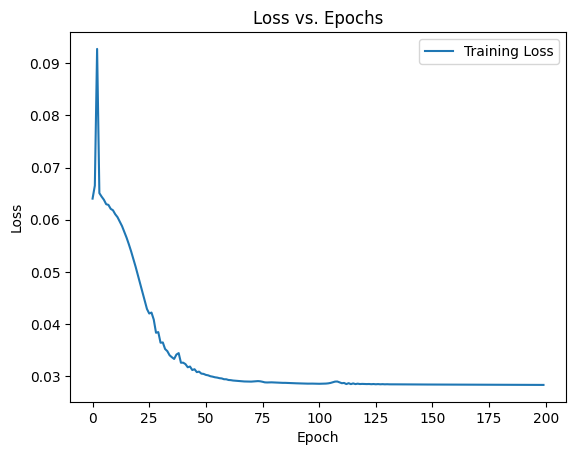

In [9]:
plt.plot(range(0, max_epoch ), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

Text(0.5, 1.0, '(c)')

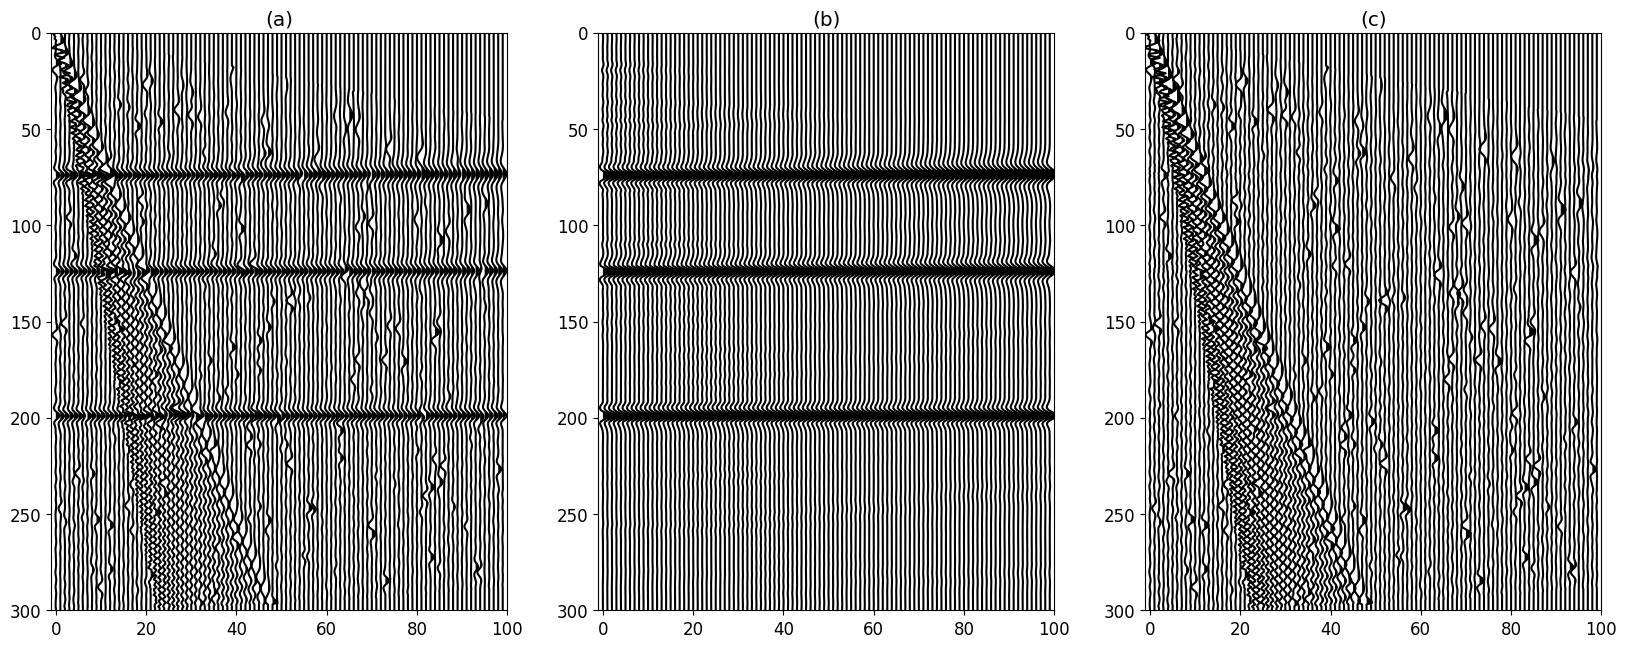

In [11]:
dr=model_output.cpu().view(d_nmo.shape[0],d_nmo.shape[1],1).detach().numpy().squeeze()  
plt.figure(figsize=(20,7.5))
plt.rcParams.update({'font.size':12})
plt.subplot(131)
wiggle(d_nmo,color='k', sf=0.3)
plt.title('(a)')
plt.subplot(132)
wiggle(dr,color='k', sf=0.3)
plt.title('(b)')
plt.subplot(133)
wiggle(d_nmo-dr,color='k', sf=0.3)
plt.title('(c)')